# K-Means

The *k*-means algorithm finds a pre-determined number of clusters. It does it using a heuristic:

- The cluster "centroid" is the mean of all the points in the cluster.
- Each point is in the cluster it's closest to.

Those two assumptions are the basis of the *k*-means model.

Kmeans has a robust implementation in `sklearn.cluster.KMeans`.

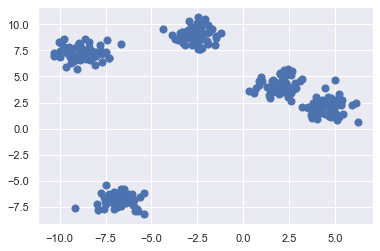

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets.samples_generator import make_blobs
sns.set()

N_CLUSTERS = 5

X, y_true = make_blobs(n_samples=300, centers=N_CLUSTERS,
                       cluster_std=0.70, random_state=42)
plt.scatter(X[:, 0], X[:, 1], s=50)

While the clusters are visible to the naked eye, we still need learn them programmatically (with sklearn):

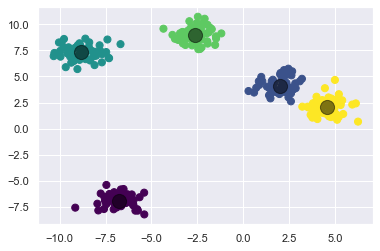

In [2]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## k-Means and the Expectation–Maximization (EM) algorithm

Like **Maximum Likelihood** we saw in module 3, EM is a general algorithm to solve both supervised and unsupervised problems.

*k*-means is a direct application of the algorithm:

1. Guess some cluster centers
2. Repeat the following until difference is small enough:
    - *E-Step*: assign points to the nearest cluster center
    - *M-Step*: set the cluster centers to the mean 

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

Like gradient descent, E-M converges toward an optimum point, which we hope will be a solution. You can use gradient descent within E-M --they're not separate concepts.

Here's a basic implementation:

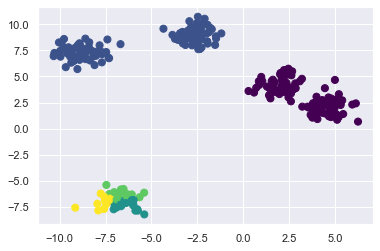

In [3]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels

centers, labels = find_clusters(X, N_CLUSTERS)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Caveats

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### 1. The globally optimal result may not be achieved

First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

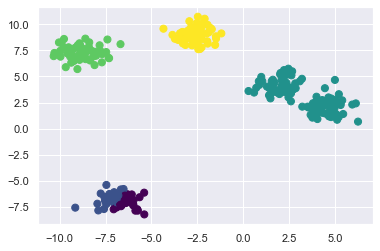

In [4]:
centers, labels = find_clusters(X, N_CLUSTERS, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the `n_init` parameter, which defaults to 10).

#### 2. k-means can be slow for large numbers of samples

Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.
This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in ``sklearn.cluster.MiniBatchKMeans``.
The interface for this is the same as for standard ``KMeans``; we will see an example of its use as we continue our discussion.

#### 3. The number of clusters must be selected beforehand

Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

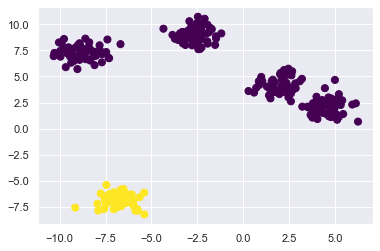

In [5]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive. This approach is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

#### 4. k-means is limited to linear cluster boundaries

The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

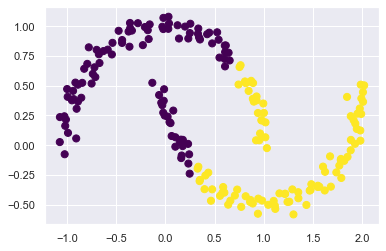

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We'll learn other algorithms, in a later lecture, that make different tradeoffs in clustering approaches. Here's one that can work on this problem called `SpectralClustering`:

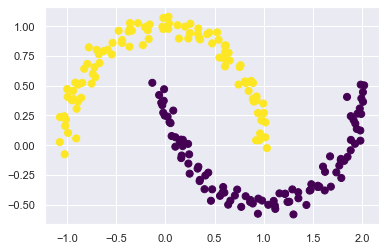

In [7]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

### k-means can be slow for large numbers of samples

Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.

This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`. The interface for this is the same as for standard `KMeans`; we will see an example of its use as we continue our discussion.

## Example: *k*-means for color compression

One interesting application of clustering is in color compression within images.
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn `datasets` module. _For this to work, you'll have to have the `pillow` Python package installed_.

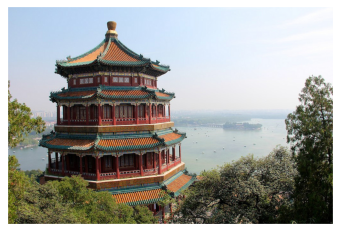

In [8]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size ``(height, width, RGB)``, containing red/blue/green contributions as integers from 0 to 255:

In [9]:
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space.
We will reshape the data to ``[n_samples x n_features]``, and rescale the colors so that they lie between 0 and 1:

In [10]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [11]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

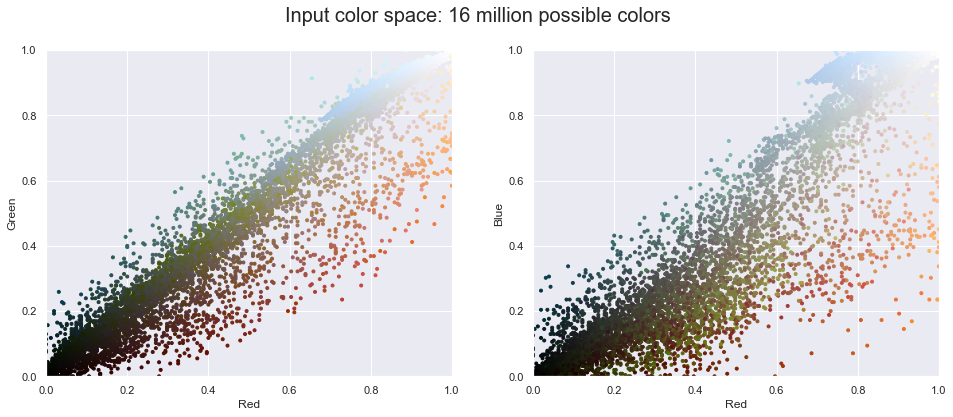

In [12]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a *k*-means clustering across the pixel space.
Because we are dealing with a very large dataset, we will use the mini batch *k*-means, which operates on subsets of the data to compute the result much more quickly than the standard *k*-means algorithm:

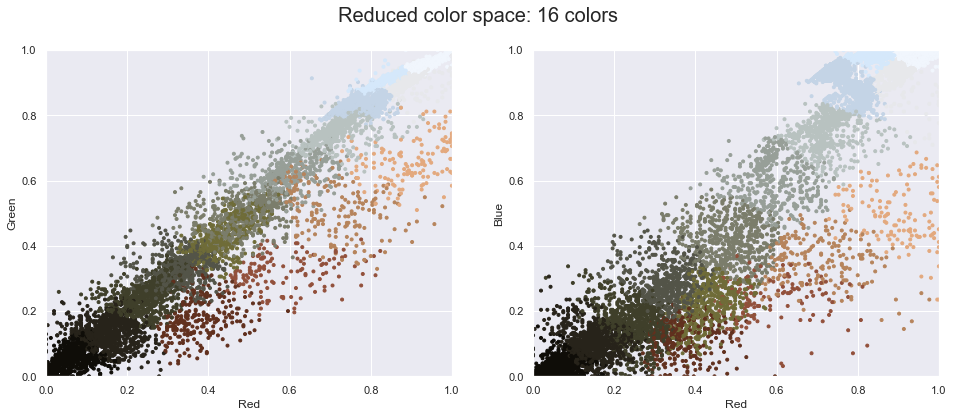

In [13]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center.
Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

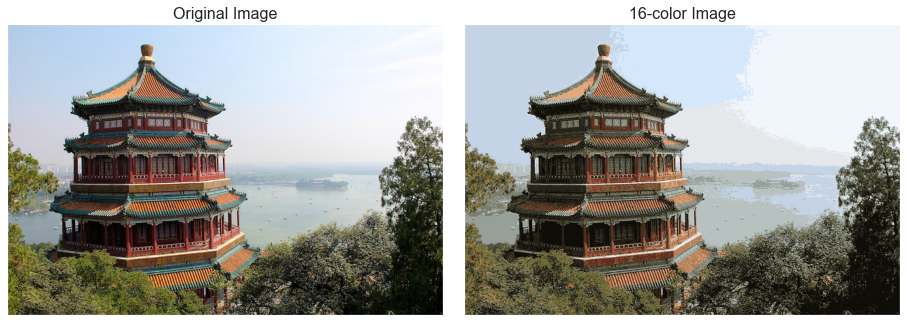

In [14]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable. The image on the right achieves a compression factor of around 1 million!

While this is an interesting application of *k*-means, there are certainly better way to compress information in images.

The example certainly shows the power of thinking outside of the box with unsupervised methods like *k*-means.